# Unrestricted Dataset

In [1]:
import pandas as pd
from rdkit import Chem
import pickle
import matplotlib.pyplot as plt

import ml
import utils
from analysis import CV, Predictions

In [2]:
andror_df_all = pd.read_csv("../andror_df_all_clusters.csv", index_col=0)

In [3]:
pix_features = pd.read_csv("../AndroR_4_final_dataset_training_ALL_STD_rdkit_pix_descriptors 2.csv", index_col=0)
andror_df_all = pd.merge(andror_df_all, pix_features, on='flat_smiles', how='inner')
andror_df_all["final class"] = andror_df_all["final class_x"] # due to the merge command, some columns are duplicated and with a suffix

In [4]:
andror_df_pub= pd.read_csv("../AndroR_4_final_dataset_training_PUB_STD_rdkit.csv", index_col=0)

In [5]:
andror_df_all["unrestricted"] = andror_df_all["Compound No_x"].isin(andror_df_pub["Compound No"])

In [6]:
rdkit_descriptors = pd.read_csv("../rdkit_descriptors.csv")

In [7]:
andror_df_pub = andror_df_all[andror_df_all["unrestricted"]]
rdkit_descriptors_pub = rdkit_descriptors.loc[andror_df_all[andror_df_all["unrestricted"]].index]

In [8]:
fps = utils.get_fingerprints(andror_df_pub)

In [9]:
groups = utils.get_cluster_assignments_from_fps(fps, 0.65, chunk_size=5000)

# Cross-validation on unrestricted Dataset

In [25]:
splits_rdkit_descriptors_unrestricted, pipelines_rdkit_descriptors_unrestricted = ml.run_or_retrieve_from_disc(
    X=rdkit_descriptors_pub, 
    y=andror_df_pub["final class"], 
    groups=groups, 
    training_name="RDKit_descriptors_unrestricted",
)

In [11]:
CV_unrestricted = CV(splits_rdkit_descriptors_unrestricted)

In [14]:
splits_rdkit_descriptors, pipelines_rdkit_descriptors = ml.run_or_retrieve_from_disc(
    X=rdkit_descriptors, 
    y=andror_df_all["final class"], 
    groups=groups, 
    training_name="RDKit_descriptors",
)

In [15]:
CV_full = CV(splits_rdkit_descriptors)

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

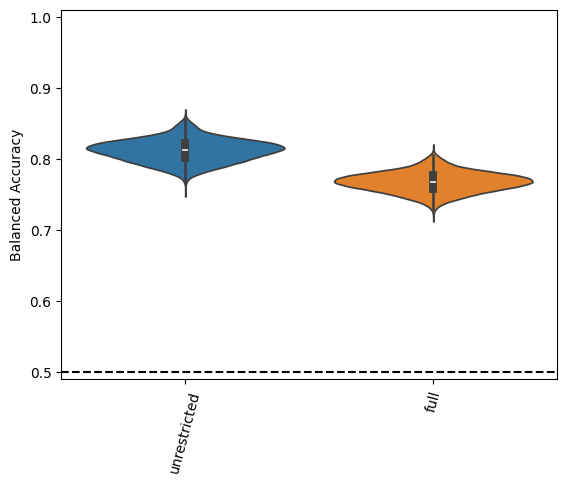

In [19]:
comparison_df = {}

label_threshold = 0.5
sel_metric = "balanced accuracy"
sample_size_posterior = 10000
prior = 1

data_dict = {
    "unrestricted": CV_unrestricted,
    "full": CV_full,
}

for feature_list, cv in data_dict.items():
    metric_estimates = []
    for fold in cv.folds:
        curr_cm = confusion_matrix(fold.y == "inhibitor", fold.y_hat_proba[:, 1] >= label_threshold, labels=[True, False])
        TP, FN, FP, TN = curr_cm.flatten()
        tpr_samples = np.random.beta(TP + prior, FN + prior, size=sample_size_posterior)
        tnr_samples = np.random.beta(TN + prior, FP + prior, size=sample_size_posterior)
        ppv_samples = np.random.beta(TP + prior, FP + prior, size=sample_size_posterior)
        npv_samples = np.random.beta(TN + prior, FN + prior, size=sample_size_posterior)
        if sel_metric == "balanced accuracy":
            curr_samples = (tpr_samples + tnr_samples) / 2
        elif sel_metric == "MCC":
            curr_samples = np.sqrt(tpr_samples * tnr_samples * ppv_samples * npv_samples) - np.sqrt(
                (1 - tpr_samples) * (1 - tnr_samples) * (1 - ppv_samples) * (1 - npv_samples))
        elif sel_metric == "NPV":
            curr_samples = npv_samples
        elif sel_metric == "TNR":
            curr_samples = tnr_samples
        elif sel_metric == "TPR":
            curr_samples = tpr_samples
        elif sel_metric == "PPV":
            curr_samples = ppv_samples
        metric_estimates += list(curr_samples)
    comparison_df[feature_list] = metric_estimates

comparison_df = pd.DataFrame(comparison_df)

sns.violinplot(comparison_df)
# rotate xlabels
plt.xticks(rotation=75)

if sel_metric == "MCC":
    plt.ylim(-0.1, 1.)
    plt.axhline(0., color='k', linestyle='--')
    plt.ylabel(f"Matthews Correlation Coefficient (MCC)")
elif sel_metric == "balanced accuracy":
    plt.ylim(0.49, 1.01)
    plt.axhline(0.5, color='k', linestyle='--')
    plt.ylabel(f"Balanced Accuracy")
elif sel_metric == "NPV":
    plt.ylim(0.95, 1.0)
    plt.ylabel(f"Negative Predictive Value (NPV)")
elif sel_metric == "PPV":
    plt.ylabel(f"Positive Predictive Value (PPV)")
elif sel_metric == "TPR":
    plt.ylabel(f"True Positive Rate (TPR)")
elif sel_metric == "TNR":
    plt.ylim(0.4, 1.0)
    plt.ylabel(f"True Negative Rate (TNR)")

# Train on Bayer HTS Data, Predict COMPARA

In [10]:
HTS_model_unrestricted = ml.create_pipeline()
sample_weights_unrestricted = ml.compute_sample_weights(andror_df_pub["final class"])
HTS_model_unrestricted.fit(
    X=rdkit_descriptors_pub, 
    y=andror_df_pub["final class"], 
    classifier__sample_weight=sample_weights_unrestricted,
)

with open("pipelines_HTS_model_unrestricted.pkl", 'wb') as f:
    pickle.dump(HTS_model_unrestricted, f)

In [12]:
with open("pipelines_HTS_model_unrestricted.pkl", 'rb') as f:
    HTS_model_unrestricted = pickle.load(f)

In [11]:
HTS_model_full = ml.create_pipeline()
sample_weights_full = ml.compute_sample_weights(andror_df_all["final class"])

HTS_model_full.fit(
    X=rdkit_descriptors, 
    y=andror_df_all["final class"], 
    classifier__sample_weight=sample_weights_full,
)
with open("pipelines_HTS_model_full.pkl", 'wb') as f:
    pickle.dump(HTS_model_full, f)

In [13]:
with open("pipelines_HTS_model_full.pkl", 'rb') as f:
    HTS_model_full = pickle.load(f)

Generate RDKit descriptors for COMPARA Dataset

In [12]:
compara_dataset = pd.read_csv("../AR_binding_CoMPARA_raw_no_stereo_unique_SMILES.txt", sep="\t")

Remove all entries from CoMPARA Dataset which are already in our internal HTS set

In [13]:
compara_dataset = compara_dataset[~compara_dataset["SMILES_STD_FLAT"].isin(andror_df_all["flat_smiles"])]

In [14]:
rdkit_descriptors_compara = utils.get_rdkit_descriptors(compara_dataset, "SMILES_STD_FLAT")

Calculating RDKit descriptors: 100%|██████████| 1654/1654 [00:26<00:00, 61.75it/s]


There is one row where entries are missing:

In [15]:
missing_columns = rdkit_descriptors_compara.columns[rdkit_descriptors_compara.isnull().any()].tolist()
missing_columns

['MaxPartialCharge',
 'MinPartialCharge',
 'MaxAbsPartialCharge',
 'MinAbsPartialCharge',
 'BCUT2D_MWHI',
 'BCUT2D_MWLOW',
 'BCUT2D_CHGHI',
 'BCUT2D_CHGLO',
 'BCUT2D_LOGPHI',
 'BCUT2D_LOGPLOW',
 'BCUT2D_MRHI',
 'BCUT2D_MRLOW']

In [16]:
missing_rows = rdkit_descriptors_compara[rdkit_descriptors_compara.isnull().any(axis=1)]
len(missing_rows)

1

Just drop this single molecule

In [17]:
rdkit_descriptors_compara = rdkit_descriptors_compara.dropna()

In [18]:
compara_dataset = compara_dataset.loc[rdkit_descriptors_compara.index]

# Predictions for COMPARA

In [19]:
compara_predictions_trained_on_unrestricted = HTS_model_unrestricted.predict_proba(
    X=rdkit_descriptors_compara,
)

In [20]:
PREDICTIONS_compara_trained_on_unrestricted = Predictions(
    y=compara_dataset["class"].replace({1.0: "inhibitor", 0.0: "inactive"}), 
    y_hat=compara_predictions_trained_on_unrestricted[:, 1] > 0.5, 
    y_hat_proba=compara_predictions_trained_on_unrestricted,
    )

In [29]:
CV_compara_trained_on_unrestricted = CV([{
    "y": compara_dataset["class"].replace({1.0: "inhibitor", 0.0: "inactive"}), 
    "y_hat": compara_predictions_trained_on_unrestricted[:, 1] > 0.5, 
    "y_hat_proba": compara_predictions_trained_on_unrestricted,}
])

In [21]:
compara_predictions_trained_on_full = HTS_model_full.predict_proba(
    X=rdkit_descriptors_compara
)

In [22]:
PREDICTIONS_compara_trained_on_full = Predictions(
    y=compara_dataset["class"].replace({1.0: "inhibitor", 0.0: "inactive"}), 
    y_hat=compara_predictions_trained_on_full[:, 1] > 0.5, 
    y_hat_proba=compara_predictions_trained_on_full,
    )

In [30]:
CV_compara_trained_on_full = CV([{
    "y": compara_dataset["class"].replace({1.0: "inhibitor", 0.0: "inactive"}), 
    "y_hat": compara_predictions_trained_on_full[:, 1] > 0.5, 
    "y_hat_proba": compara_predictions_trained_on_full,}
])

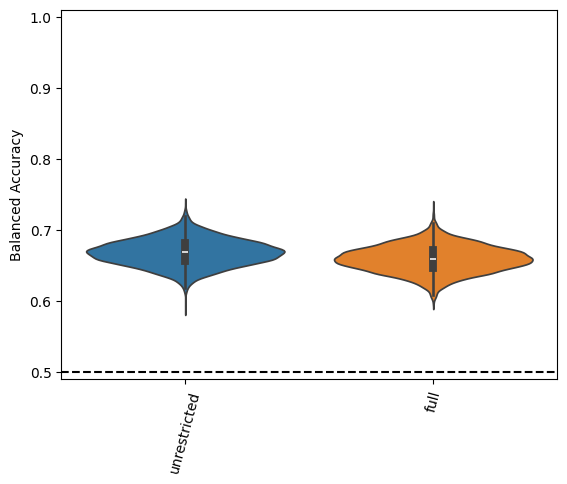

In [33]:
comparison_df = {}

label_threshold = 0.5
sel_metric = "balanced accuracy"
sample_size_posterior = 10000
prior = 1

data_dict = {
    "unrestricted": CV_compara_trained_on_unrestricted,
    "full": CV_compara_trained_on_full,
}

for feature_list, cv in data_dict.items():
    metric_estimates = []
    for fold in cv.folds:
        curr_cm = confusion_matrix(fold.y == "inhibitor", fold.y_hat_proba[:, 1] >= label_threshold, labels=[True, False])
        TP, FN, FP, TN = curr_cm.flatten()
        tpr_samples = np.random.beta(TP + prior, FN + prior, size=sample_size_posterior)
        tnr_samples = np.random.beta(TN + prior, FP + prior, size=sample_size_posterior)
        ppv_samples = np.random.beta(TP + prior, FP + prior, size=sample_size_posterior)
        npv_samples = np.random.beta(TN + prior, FN + prior, size=sample_size_posterior)
        if sel_metric == "balanced accuracy":
            curr_samples = (tpr_samples + tnr_samples) / 2
        elif sel_metric == "MCC":
            curr_samples = np.sqrt(tpr_samples * tnr_samples * ppv_samples * npv_samples) - np.sqrt(
                (1 - tpr_samples) * (1 - tnr_samples) * (1 - ppv_samples) * (1 - npv_samples))
        elif sel_metric == "NPV":
            curr_samples = npv_samples
        elif sel_metric == "TNR":
            curr_samples = tnr_samples
        elif sel_metric == "TPR":
            curr_samples = tpr_samples
        elif sel_metric == "PPV":
            curr_samples = ppv_samples
        metric_estimates += list(curr_samples)
    comparison_df[feature_list] = metric_estimates

comparison_df = pd.DataFrame(comparison_df)

sns.violinplot(comparison_df)
# rotate xlabels
plt.xticks(rotation=75)

if sel_metric == "MCC":
    plt.ylim(-0.1, 1.)
    plt.axhline(0., color='k', linestyle='--')
    plt.ylabel(f"Matthews Correlation Coefficient (MCC)")
elif sel_metric == "balanced accuracy":
    plt.ylim(0.49, 1.01)
    plt.axhline(0.5, color='k', linestyle='--')
    plt.ylabel(f"Balanced Accuracy")
elif sel_metric == "NPV":
    plt.ylim(0.95, 1.0)
    plt.ylabel(f"Negative Predictive Value (NPV)")
elif sel_metric == "PPV":
    plt.ylabel(f"Positive Predictive Value (PPV)")
elif sel_metric == "TPR":
    plt.ylabel(f"True Positive Rate (TPR)")
elif sel_metric == "TNR":
    plt.ylim(0.4, 1.0)
    plt.ylabel(f"True Negative Rate (TNR)")

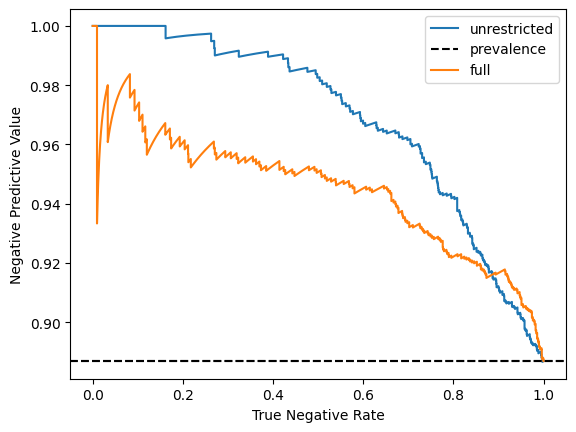

In [45]:
PREDICTIONS_compara_trained_on_unrestricted.plot_npv_tnr_curve()
PREDICTIONS_compara_trained_on_full.plot_npv_tnr_curve()
plt.legend(["unrestricted", "prevalence", "full"])